In [2]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
import pack_ga
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
stop final relax at some point
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties fo

In [3]:
%load_ext pyinstrument

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


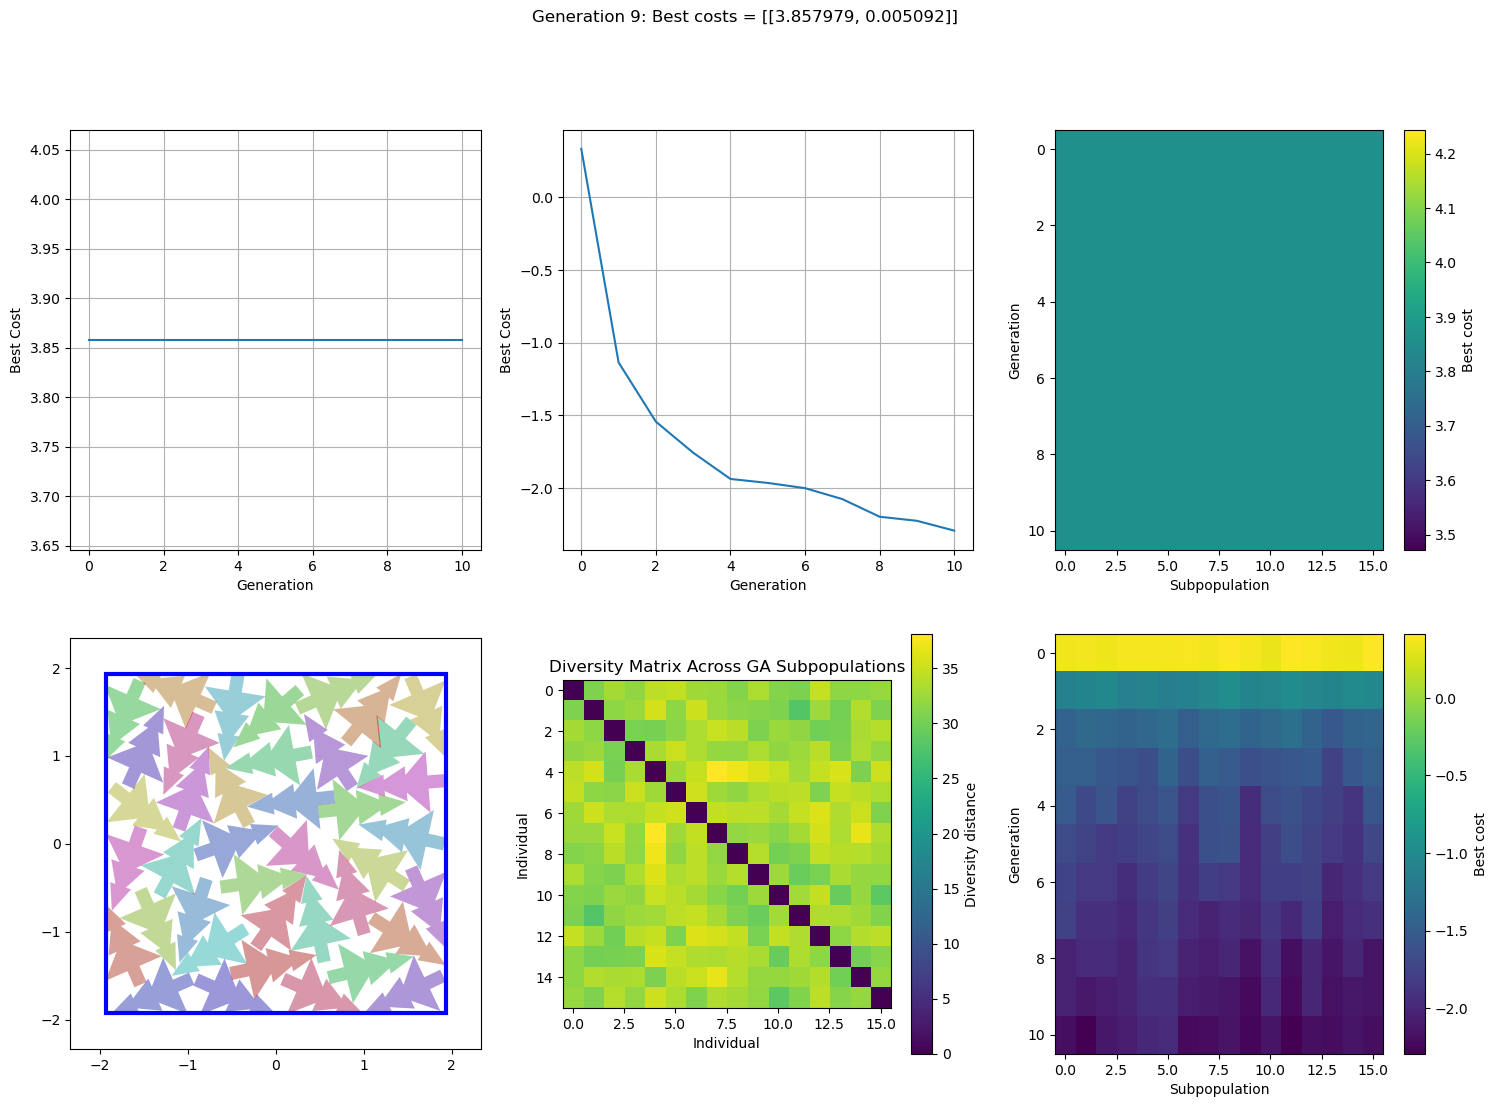

In [ ]:
# %%pyinstrument
# kgs.profiling=True
# %matplotlib widget
import pack_ga3 as pack_ga2
import pack_runner
importlib.reload(pack_ga2)
fastMode = False
kgs.debugging_mode = 2

tmp = pack_ga2.GA()

runner = pack_ga2.Orchestrator(n_generations=6000 if not fastMode else 50)
runner.ga = pack_ga2.GAMultiRing(N=16 if not fastMode else 4)
#runner.ga.mate_distance=16 if not fastMode else 2

ga_base = pack_ga2.GASinglePopulationOld(N_trees_to_do=40)
#ga_base.population_size = 250
#ga_base.prob_mate_own = 0.25
value = 0.125
ga_base.population_size = int(ga_base.population_size * value)
ga_base.selection_size = [int( (s-1) * value)+1 for s in ga_base.selection_size]
ga_base.do_legalize = False
ga_base.reset_check_generations = 50 if not fastMode else 3
ga_base.reset_check_threshold = 0.5 if not fastMode else 0.9
ga_base.freeze_duration = 100 if not fastMode else 3
#ga_base.move.moves[-1][2] *= 2
ga_base.prob_mate_own = 0.9

runner.ga.ga_base = ga_base
runner.ga.do_legalize = False
runner.ga.allow_reset_ratio = 0.5 if not fastMode else 0.
runner.ga.best_costs_per_generation_ax = ( (0,False,(0,0)) ,(1,True,(0,1)))
runner.ga.plot_subpopulation_costs_per_generation_ax = ( (0,False,(0,2)) ,(1,True,(1,2)))
runner.ga.champion_ax = (1,0)
runner.ga.plot_diversity_ax = (1,1)
runner.diagnostic_plot = True
runner.seed = 0

runner.run()